# Transit Station - Census Tract Analysis

The purpose of this program is to identify the census tracts that fall within a 1/4 mile of qualifying bus stops and a 1/2 mile of rail stations in California.

In [1]:
import pandas as pd, numpy as np
from shapely.geometry import Polygon
from shapely.geometry import Point
import geopandas

import matplotlib.pyplot as plot

In [2]:
geo_path = 'GIS/Tracts/cb_2017_06_tract_500k/' # select folder with data in it
ca_tracts = geopandas.read_file(geo_path + 'cb_2017_06_tract_500k.shp')

[]

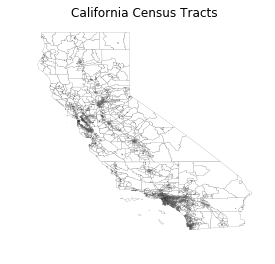

In [6]:
# I want to plot the census tracts shapefile to make sure it was read in correctly 

DPI=100
ax = ca_tracts.plot(color='white', edgecolor='black', linewidth=.1)
ax.set_axis_off()
ax.set_title('California Census Tracts')
ax.plot()

[]

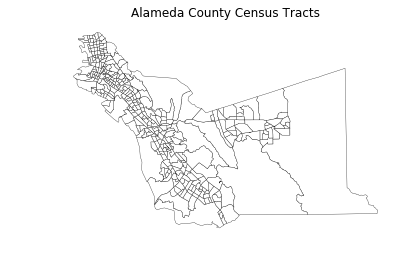

In [22]:
# let's check Alameda County to see the tracts in a little more detail

ax = ca_tracts[ca_tracts.COUNTYFP=='001'].plot(color='white', edgecolor='black', linewidth=.3)
DPI=100
ax.set_axis_off()
ax.set_title('Alameda County Census Tracts')
ax.plot()

I think we need to change the Coordinate Reference System to be able to measure the buffers around the stations. I think the default uses the euclidean distance and measures in degrees or something and I don't know how to interpret that.

We'll use the MTC standardized CRS for now and the unit of meters. We may want to switch to a better state-wide representation or do different parts of the state separately if we want to get more exact. MTC has standardized on Universal Transverse Mercator (UTM), Zone 10N, NAD83 for all analysis based projects.

In [12]:
print(ca_tracts.crs)

mtc_crs = '+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs '
ca_tracts = ca_tracts.to_crs(mtc_crs)

print(ca_tracts.crs)

{'init': 'epsg:4269'}
+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs 


We want to add the area of the tract here so we can use it to help filter out the tracts with less overlap later. We'll also change the area unit from square miles to square kilometers.

In [13]:
ca_tracts["tract_area"] = ca_tracts['geometry'].area / 10**6

ca_tracts.head(2)

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,tract_area
0,06,001,400600,1400000US06001400600,06001400600,4006,CT,297856,0,"POLYGON ((564397.7068758229 4188774.178144514,...",0.301476
1,06,001,400900,1400000US06001400900,06001400900,4009,CT,420877,0,"POLYGON ((562861.1478494926 4188278.724707939,...",0.435518


In [14]:
stop_path = 'station_id/'

dtypes = {'Stop ID': 'str', 'Name': 'str', 'Agency': 'str', 'OB Routes': 'str', 'IB Routes': 'str'}
stops = pd.read_csv(stop_path + 'AllBus.csv', delimiter=',', dtype=dtypes)

dtypes2 = {'Stop ID': 'str', 'Name': 'str', 'Agency': 'str'}
stations = pd.read_csv(stop_path + 'AllRail.csv', delimiter=',', dtype=dtypes2)
print(len(stops))
print(len(stations))
stops.head(1)

98913
1445


,Unnamed: 0,Stop ID,Name,Agency,X,Y,OB Routes,OB AM Peak,OB PM Peak,OB Weekday,OB Saturday,OB Sunday,IB Routes,IB AM Peak,IB PM Peak,IB Weekday,IB Saturday,IB Sunday
0,0,777402,San Jose Caltrain Station,Caltrain,-121.901985,37.330196,TaSJ-Shuttle,NaN,NaN,NaN,93.33,93.33,TaSJ-Shuttle,NaN,NaN,NaN,70.0,70.0


In [15]:
stations.head(1)

,Unnamed: 0,Stop ID,Name,Agency,X,Y
0,0,70261,San Jose Diridon Caltrain,Caltrain,-121.903011,37.329239


Now we will limit the bus stops based on the criteria we have defined. In SB 827, this was:

--> 15-minute headways during the AM Peak (6am - 10am) and PM Peak (3pm - 7pm)

--> 20-minute headways every weekday from 6am - 10am

--> 30-minute headways on Saturday and Sunday from 8am - 10pm

We do not need to drop any rail stations since all of these qualify for upzoning

In [16]:
qual_stops = stops[((stops['OB AM Peak']<=15) | (stops['IB AM Peak']<=15)) & 
                   ((stops['OB PM Peak']<=15) | (stops['IB PM Peak']<=15)) & 
                   ((stops['OB Weekday']<=20) | (stops['IB Weekday']<=20)) & 
                   ((stops['OB Saturday']<=30) | (stops['IB Saturday']<=30)) & 
                   ((stops['OB Sunday']<=30) | (stops['IB Sunday']<=30))].reset_index()
print(len(qual_stops))

15635


Next step is to use the longitude and latitude variables (X and Y) to transform this dataframe into a database

In [17]:
qual_stops['Coordinates'] = list(zip(qual_stops.X, qual_stops.Y))
qual_stops['Coordinates'] = qual_stops['Coordinates'].apply(Point)
geo_stops = geopandas.GeoDataFrame(qual_stops, geometry='Coordinates')

Let's do the same for the rail stations:

In [18]:
stations['Coordinates'] = list(zip(stations.X, stations.Y))
stations['Coordinates'] = stations['Coordinates'].apply(Point)
geo_stations = geopandas.GeoDataFrame(stations, geometry='Coordinates')

Now we need to switch the coordinate reference systems to match the CRS of the tracts. This way they will be projected the same way when we overlay them

In [19]:
geo_stops.crs = {'init': 'epsg:4269'}
print(geo_stops.crs)

geo_stops = geo_stops.to_crs(mtc_crs)
print(geo_stops.crs)

geo_stations.crs = {'init': 'epsg:4269'}
print(geo_stations.crs)

geo_stations = geo_stations.to_crs(mtc_crs)
print(geo_stations.crs)

{'init': 'epsg:4269'}
+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs 
{'init': 'epsg:4269'}
+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs 


Let's plot the bus stops geodataframe on top of the census tracts geodataframe to see how it looks

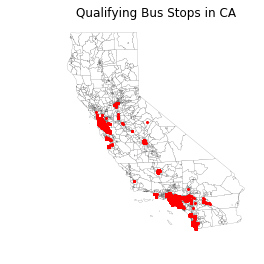

In [21]:
ax = ca_tracts.plot(color='white', edgecolor='black', linewidth=.1)
DPI=100
ax.set_axis_off()
ax.set_title('Qualifying Bus Stops in CA')
geo_stops.plot(ax=ax, color='red', markersize=4)

Now we have to try to buffer the 1/4 mile radius around the bus stations and the 1/2 mile radius around the rail stations. The units of the projection are meters, so we'll use 402 meters for 1/4 mile and 804 meters for 1/2 mile.

We'll replace the original point Coordinates with polygons that have the circles since I haven't figured out how to make it work in a separate column. We'll also add the area of the buffer as station_area. These should be the same for every station since it should be pi*r^2.

In [23]:
geo_stops['Coordinates'] = geo_stops['Coordinates'].buffer(402.33)
geo_stops["station_area"] = geo_stops['Coordinates'].area / 10**6

geo_stops.head(2)

,index,Unnamed: 0,Stop ID,Name,Agency,X,Y,OB Routes,OB AM Peak,OB PM Peak,...,OB Saturday,OB Sunday,IB Routes,IB AM Peak,IB PM Peak,IB Weekday,IB Saturday,IB Sunday,Coordinates,station_area
0,2,0,2452018,San Rafael Transit Center,Marin Transit,-122.523102,37.971081,"125, 245, 29, 22, 49, 228, 35, 68, 233, 36, 25...",8.00,7.50,...,10.91,10.91,"125, 245, 29, 22, 49, 228, 35, 68, 233, 36, 25...",7.74,8.89,8.97,9.44,9.55,"POLYGON ((542289.2558724623 4202713.659785125,...",0.507711
1,6,4,2452345,Reed Blvd & Redwood Hwy,Marin Transit,-122.514992,37.901085,"17, 22, 115",18.46,18.46,...,30.00,30.00,"219, 17, 22",13.33,12.00,14.12,19.09,19.09,"POLYGON ((543041.995031161 4194951.153077608, ...",0.507711


In [24]:
geo_stations['Coordinates'] = geo_stations['Coordinates'].buffer(804.67)
geo_stations["station_area"] = geo_stations['Coordinates'].area / 10**6

geo_stations.head(2)

,Unnamed: 0,Stop ID,Name,Agency,X,Y,Coordinates,station_area
0,0,70261,San Jose Diridon Caltrain,Caltrain,-121.903011,37.329239,"POLYGON ((597989.5707444021 4131961.140504893,...",2.030896
1,1,70241,Santa Clara Caltrain,Caltrain,-121.936080,37.353238,"POLYGON ((595029.8245479942 4134590.197798677,...",2.030896


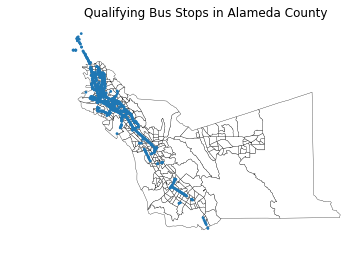

In [31]:
#Let's check bus stations for Alameda

base = ca_tracts[ca_tracts.COUNTYFP=='001'].plot(color='white', edgecolor='black', linewidth=.3)
DPI=100
base.set_axis_off()
base.set_title('Qualifying Bus Stops in Alameda County')
geo_stops[geo_stops.Agency=='AC Transit'].plot(ax=base);

In [15]:
#Let's export this layer to check with Transit Rich Housing
#geo_stops.to_csv('geo_stops.csv')
geo_stops.to_file('geo_stops.shp')

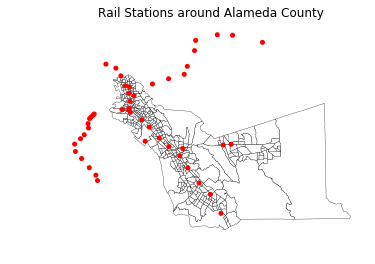

In [30]:
#Let's also check rail stations for Alameda/BART

base = ca_tracts[ca_tracts.COUNTYFP=='001'].plot(color='white', edgecolor='black', linewidth=.3)
DPI=100
base.set_axis_off()
base.set_title('Rail Stations around Alameda County')
geo_stations[geo_stations.Agency=='Bay Area Rapid Transit'].plot(ax=base, color = 'red');

In [32]:
#Let's combine and export these shapes so we can make maps of the clusters later
rail_bus = geo_stops.append(geo_stations, ignore_index=True)

#need to create the unique key
rail_bus['key'] = rail_bus['Agency'] + rail_bus['Stop ID']

#need to remove duplicates
print(len(rail_bus))
rail_bus.drop_duplicates(subset ='key', keep = "first", inplace = True) 
print(len(rail_bus))

#change coordinate reference system back so we have lat and long
rail_bus = rail_bus.to_crs({'init': 'epsg:4269'})
print(rail_bus.crs)

rail_bus.to_file('rail_bus.shp')      

17080
10663
{'init': 'epsg:4269'}


Now for the most crucial part! Overlaying the station buffers over the census tract boundaries to figure out what census tracts are contained inside which stations!

In [33]:
bus_union = geopandas.overlay(ca_tracts, geo_stops, how='intersection')

bus_union.head(2)

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,tract_area,...,OB Saturday,OB Sunday,IB Routes,IB AM Peak,IB PM Peak,IB Weekday,IB Saturday,IB Sunday,station_area,geometry
0,06,001,400600,1400000US06001400600,06001400600,4006,CT,297856,0,0.301476,...,NaN,NaN,"6, 800",10.43,10.0,11.43,15.0,15.0,0.507711,"POLYGON ((564979.0162317713 4188758.451345737,..."
17617,06,001,400400,1400000US06001400400,06001400400,4004,CT,714728,0,0.720770,...,NaN,NaN,"6, 800",10.43,10.0,11.43,15.0,15.0,0.507711,"POLYGON ((564950.9881445128 4188518.22503095, ..."


In [17]:
rail_union = geopandas.overlay(ca_tracts, geo_stations, how='intersection')

rail_union.head(2)

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,tract_area,Unnamed: 0,Stop ID,Name,Agency,X,Y,station_area,geometry
0,06,001,400900,1400000US06001400900,06001400900,4009,CT,420877,0,0.435518,1,EMY,Emeryville,Capitol Corridor Joint Powers Authority,-122.291808,37.840423,2.030896,"POLYGON ((562861.1478494926 4188278.724707939,..."
2912,06,001,400800,1400000US06001400800,06001400800,4008,CT,696240,0,0.691833,1,EMY,Emeryville,Capitol Corridor Joint Powers Authority,-122.291808,37.840423,2.030896,"POLYGON ((563111.4492145893 4188435.766072571,..."


Next we want to calculate the area of the census tract polygon that is inside of the station area

In [18]:
bus_union["overlap_area"] = bus_union['geometry'].area / 10**6
rail_union["overlap_area"] = rail_union['geometry'].area / 10**6

bus_union.to_csv('tract_stop_intersection.csv')
rail_union.to_csv('tract_station_intersection.csv')

At the end of the dataframe there are many weird shapes/polygons that are part of the station geometry but are unmatched to census tracts. For now I'm just dropping those since the tracts appear to all be matched.

^this does not seem to happen when I went from using the "union" to the "intersection"

In [19]:
print(len(bus_union))

match_tract = bus_union[(pd.isnull(bus_union['Stop ID'])==False) & (pd.isnull(bus_union['AFFGEOID'])==False)]

print(len(match_tract))

63751
63751


Here we make some calculations to help us decide which census tracts we should keep. The two metrics are the share of the census tract that is inside of the station buffer and the share of the total station buffer that is taken up by the census tract.

To make sure each station/stop has at least one census tract matched with it, we'll add these two metrics together and keep the census tract that has the highest combined share.

In [20]:
#import warnings
#warnings.fiterwarnings('ignore')

bus_union['tract_inside_station'] = bus_union['overlap_area'] / bus_union['tract_area']
bus_union['share_of_station'] = bus_union['overlap_area'] / bus_union['station_area']
bus_union['added_shares'] = bus_union['tract_inside_station'] + bus_union['share_of_station']

rail_union['tract_inside_station'] = rail_union['overlap_area'] / rail_union['tract_area']
rail_union['share_of_station'] = rail_union['overlap_area'] / rail_union['station_area']
rail_union['added_shares'] = rail_union['tract_inside_station'] + rail_union['share_of_station']

In [21]:
#Need to have a unique key since some agencies have the same Stop ID!

bus_union['key'] = bus_union['Agency'] + bus_union['Stop ID']
rail_union['key'] = rail_union['Agency'] + rail_union['Stop ID']

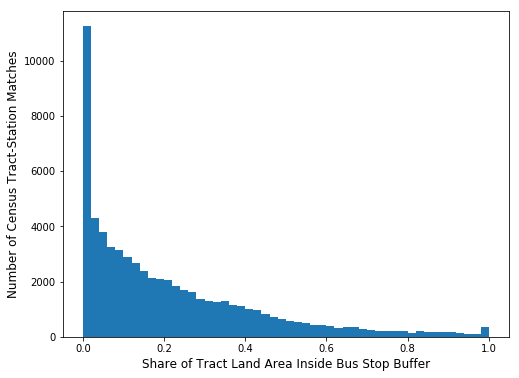

In [22]:
plot.figure(1, figsize=(8,6), )
plot.xlabel('Share of Tract Land Area Inside Bus Stop Buffer', fontsize=12)
plot.ylabel('Number of Census Tract-Station Matches', fontsize=12)
ax = plot.hist(bus_union['tract_inside_station'], bins=50)
plot.savefig('tract_inside_station.png')
plot.show()

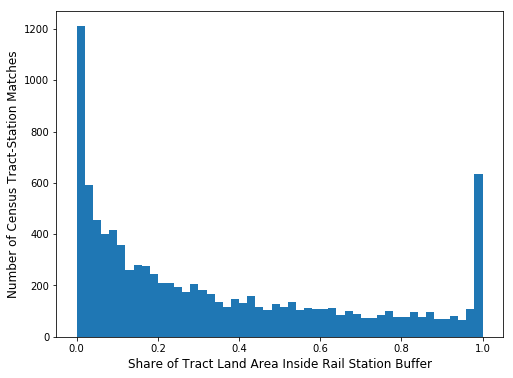

In [23]:
plot.figure(1, figsize=(8,6), )
plot.xlabel('Share of Tract Land Area Inside Rail Station Buffer', fontsize=12)
plot.ylabel('Number of Census Tract-Station Matches', fontsize=12)
ax = plot.hist(rail_union['tract_inside_station'], bins=50)
plot.savefig('tract_inside_station.png')
plot.show()

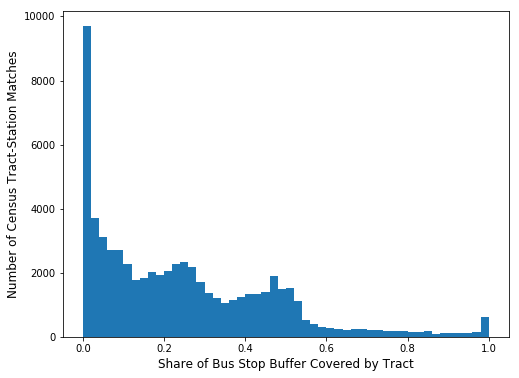

In [24]:
plot.figure(1, figsize=(8,6), )
plot.xlabel('Share of Bus Stop Buffer Covered by Tract', fontsize=12)
plot.ylabel('Number of Census Tract-Station Matches', fontsize=12)
ax = plot.hist(bus_union['share_of_station'], bins=50)
plot.savefig('share_of_station.png')
plot.show()

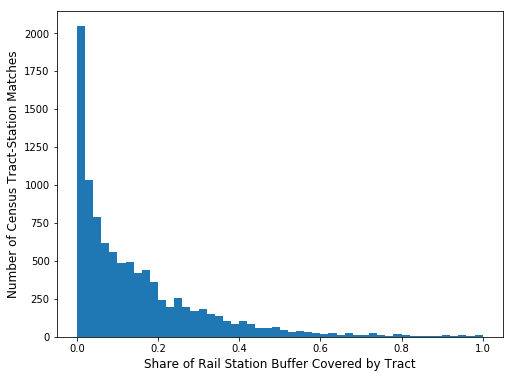

In [25]:
plot.figure(1, figsize=(8,6), )
plot.xlabel('Share of Rail Station Buffer Covered by Tract', fontsize=12)
plot.ylabel('Number of Census Tract-Station Matches', fontsize=12)
ax = plot.hist(rail_union['share_of_station'], bins=50)
plot.savefig('share_of_station.png')
plot.show()

In [26]:
sorted_bus = bus_union.sort_values(by=['Agency', 'Stop ID', 'added_shares'], ascending=False)
sorted_bus.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,tract_area,...,IB Weekday,IB Saturday,IB Sunday,station_area,geometry,overlap_area,tract_inside_station,share_of_station,added_shares,key
3814,06,043,000400,1400000US06043000400,06043000400,4,CT,1019237193,4456561,1025.605497,...,NaN,NaN,NaN,0.507711,"POLYGON ((801245.0431922717 4182865.720460022,...",0.507711,0.000495,1.000000,1.000495,Yosemite Valley Shuttle System766882
67843,06,071,009910,1400000US06071009910,06071009910,99.10,CT,4387752,0,4.403783,...,15.74,28.97,35.0,0.507711,"POLYGON ((1019267.173736518 3829647.657939956,...",0.440581,0.100046,0.867779,0.967825,Victor Valley Transit Authority813390
7586,06,071,010025,1400000US06071010025,06071010025,100.25,CT,6887040,0,6.929974,...,15.74,28.97,35.0,0.507711,"POLYGON ((1019583.7834962 3828932.718031033, 1...",0.061253,0.008839,0.120644,0.129483,Victor Valley Transit Authority813390
33196,06,071,009908,1400000US06071009908,06071009908,99.08,CT,2233451,0,2.251246,...,15.74,28.97,35.0,0.507711,"POLYGON ((1019422.880323802 3829720.3560201, 1...",0.005878,0.002611,0.011577,0.014188,Victor Valley Transit Authority813390
86455,06,085,508602,1400000US06085508602,06085508602,5086.02,CT,1340639,0,1.342321,...,NaN,NaN,NaN,0.507711,"POLYGON ((585442.9790804776 4136955.199932395,...",0.326733,0.243409,0.643542,0.886951,VTA864


In [27]:
sorted_bus['best_match'] = (sorted_bus.groupby('key').cumcount() == 0)
sorted_bus.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,tract_area,...,IB Saturday,IB Sunday,station_area,geometry,overlap_area,tract_inside_station,share_of_station,added_shares,key,best_match
3814,06,043,000400,1400000US06043000400,06043000400,4,CT,1019237193,4456561,1025.605497,...,NaN,NaN,0.507711,"POLYGON ((801245.0431922717 4182865.720460022,...",0.507711,0.000495,1.000000,1.000495,Yosemite Valley Shuttle System766882,True
67843,06,071,009910,1400000US06071009910,06071009910,99.10,CT,4387752,0,4.403783,...,28.97,35.0,0.507711,"POLYGON ((1019267.173736518 3829647.657939956,...",0.440581,0.100046,0.867779,0.967825,Victor Valley Transit Authority813390,True
7586,06,071,010025,1400000US06071010025,06071010025,100.25,CT,6887040,0,6.929974,...,28.97,35.0,0.507711,"POLYGON ((1019583.7834962 3828932.718031033, 1...",0.061253,0.008839,0.120644,0.129483,Victor Valley Transit Authority813390,False
33196,06,071,009908,1400000US06071009908,06071009908,99.08,CT,2233451,0,2.251246,...,28.97,35.0,0.507711,"POLYGON ((1019422.880323802 3829720.3560201, 1...",0.005878,0.002611,0.011577,0.014188,Victor Valley Transit Authority813390,False
86455,06,085,508602,1400000US06085508602,06085508602,5086.02,CT,1340639,0,1.342321,...,NaN,NaN,0.507711,"POLYGON ((585442.9790804776 4136955.199932395,...",0.326733,0.243409,0.643542,0.886951,VTA864,True


This is a check to make sure that stops with the same Stop ID that are run by different agencies all have their own best match

In [28]:
sorted_bus[sorted_bus['Stop ID'] == '4']

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,tract_area,...,IB Saturday,IB Sunday,station_area,geometry,overlap_area,tract_inside_station,share_of_station,added_shares,key,best_match
45388,06,071,005701,1400000US06071005701,06071005701,57.01,CT,3483780,0,3.506454,...,21.00,24.0,0.507711,"POLYGON ((1027015.303094062 3788491.565738968,...",0.507711,0.144793,1.000000,1.144793,OMNITRANS4,True
32740,06,037,576301,1400000US06037576301,06037576301,5763.01,CT,548534,0,0.550547,...,9.88,10.5,0.507711,"POLYGON ((945324.9708060201 3747976.150167639,...",0.455304,0.827002,0.896777,1.723779,Long Beach Transit4,True
3470,06,037,575803,1400000US06037575803,06037575803,5758.03,CT,199588,0,0.200376,...,9.88,10.5,0.507711,"POLYGON ((945306.1933803253 3748367.038392833,...",0.042346,0.211334,0.083406,0.294739,Long Beach Transit4,False
62151,06,037,575402,1400000US06037575402,06037575402,5754.02,CT,323805,0,0.325438,...,9.88,10.5,0.507711,"POLYGON ((945578.4847903407 3748504.647654087,...",0.003976,0.012216,0.007831,0.020047,Long Beach Transit4,False
62107,06,037,575300,1400000US06037575300,06037575300,5753,CT,648066,0,0.650948,...,9.88,10.5,0.507711,"POLYGON ((945764.656648536 3748475.245944616, ...",0.004931,0.007575,0.009712,0.017287,Long Beach Transit4,False
62266,06,037,576302,1400000US06037576302,06037576302,5763.02,CT,323710,0,0.324712,...,9.88,10.5,0.507711,"POLYGON ((946003.6600456464 3748082.572527927,...",0.001155,0.003557,0.002275,0.005832,Long Beach Transit4,False
43947,06,037,701902,1400000US06037701902,06037701902,7019.02,CT,1790959,439378,1.664585,...,NaN,NaN,0.507711,"POLYGON ((916504.0623059893 3773135.499213432,...",0.507711,0.305008,1.000000,1.305008,Big Blue Bus4,True


Time to do the same procedure for the rail stations

In [29]:
sorted_rail = rail_union.sort_values(by=['Agency', 'Stop ID', 'added_shares'], ascending=False)

sorted_rail['best_match'] = (sorted_rail.groupby('key').cumcount() == 0)
sorted_rail.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,tract_area,...,X,Y,station_area,geometry,overlap_area,tract_inside_station,share_of_station,added_shares,key,best_match
3849,06,085,500800,1400000US06085500800,06085500800,5008,CT,1678457,0,1.672477,...,-121.899045,37.330248,2.030896,"POLYGON ((597242.4520783753 4131328.302681415,...",1.110233,0.663826,0.546672,1.210497,VTA5389,True
9103,06,085,500300,1400000US06085500300,06085500300,5003,CT,2922360,0,2.923657,...,-121.899045,37.330248,2.030896,"POLYGON ((597365.8641960224 4132863.390439347,...",0.724353,0.247756,0.356667,0.604423,VTA5389,False
3975,06,085,501900,1400000US06085501900,06085501900,5019,CT,1546139,0,1.547568,...,-121.899045,37.330248,2.030896,"POLYGON ((596871.9325265817 4131622.097176665,...",0.100313,0.064820,0.049394,0.114214,VTA5389,False
1942,06,085,500600,1400000US06085500600,06085500600,5006,CT,1345945,0,1.345984,...,-121.899045,37.330248,2.030896,"POLYGON ((596867.7507412589 4132526.71632643, ...",0.059540,0.044235,0.029317,0.073552,VTA5389,False
8427,06,085,501700,1400000US06085501700,06085501700,5017,CT,1114858,0,1.117757,...,-121.899045,37.330248,2.030896,"POLYGON ((598102.1427676403 4131917.692750471,...",0.036456,0.032615,0.017951,0.050566,VTA5389,False


Now we'll decide which tracts we want to keep to draw demographic information from. For each station we'll definitely keep the 'best match' that we just determined, in addition to tracts that have both 20% of their land area within the station radius and account for 20% of the station buffer.

In [30]:
sorted_bus['keep'] = (sorted_bus['best_match'] == True) | ((sorted_bus['tract_inside_station'] > 0.2) & (sorted_bus['share_of_station'] > 0.2))

sorted_bus.head(10)

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,tract_area,...,IB Sunday,station_area,geometry,overlap_area,tract_inside_station,share_of_station,added_shares,key,best_match,keep
3814,06,043,000400,1400000US06043000400,06043000400,4,CT,1019237193,4456561,1025.605497,...,NaN,0.507711,"POLYGON ((801245.0431922717 4182865.720460022,...",0.507711,0.000495,1.000000,1.000495,Yosemite Valley Shuttle System766882,True,True
67843,06,071,009910,1400000US06071009910,06071009910,99.10,CT,4387752,0,4.403783,...,35.00,0.507711,"POLYGON ((1019267.173736518 3829647.657939956,...",0.440581,0.100046,0.867779,0.967825,Victor Valley Transit Authority813390,True,True
7586,06,071,010025,1400000US06071010025,06071010025,100.25,CT,6887040,0,6.929974,...,35.00,0.507711,"POLYGON ((1019583.7834962 3828932.718031033, 1...",0.061253,0.008839,0.120644,0.129483,Victor Valley Transit Authority813390,False,False
33196,06,071,009908,1400000US06071009908,06071009908,99.08,CT,2233451,0,2.251246,...,35.00,0.507711,"POLYGON ((1019422.880323802 3829720.3560201, 1...",0.005878,0.002611,0.011577,0.014188,Victor Valley Transit Authority813390,False,False
86455,06,085,508602,1400000US06085508602,06085508602,5086.02,CT,1340639,0,1.342321,...,NaN,0.507711,"POLYGON ((585442.9790804776 4136955.199932395,...",0.326733,0.243409,0.643542,0.886951,VTA864,True,True
64244,06,085,508704,1400000US06085508704,06085508704,5087.04,CT,5999099,0,5.988864,...,NaN,0.507711,"POLYGON ((586188.0811176173 4137166.651192358,...",0.132081,0.022054,0.260150,0.282205,VTA864,False,False
64242,06,085,508601,1400000US06085508601,06085508601,5086.01,CT,1319970,0,1.319636,...,NaN,0.507711,"POLYGON ((585495.6416939715 4137443.003594513,...",0.045496,0.034476,0.089610,0.124086,VTA864,False,False
72066,06,085,509102,1400000US06085509102,06085509102,5091.02,CT,3114195,0,3.121713,...,NaN,0.507711,"POLYGON ((585580.294571036 4137510.11214586, 5...",0.003401,0.001089,0.006698,0.007788,VTA864,False,False
13562,06,085,502101,1400000US06085502101,06085502101,5021.01,CT,1923537,0,1.919669,...,22.11,0.507711,"POLYGON ((593887.7986309242 4129715.191121247,...",0.387729,0.201977,0.763680,0.965657,VTA818,True,True
63953,06,085,506401,1400000US06085506401,06085506401,5064.01,CT,1343313,0,1.336104,...,22.11,0.507711,"POLYGON ((593903.876950832 4130442.020575042, ...",0.118685,0.088829,0.233765,0.322594,VTA818,False,False


In [31]:
sorted_rail['keep'] = (sorted_rail['best_match'] == True) | ((sorted_rail['tract_inside_station'] > 0.2) & (sorted_rail['share_of_station'] > 0.2))

sorted_rail.head(5)

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,tract_area,...,Y,station_area,geometry,overlap_area,tract_inside_station,share_of_station,added_shares,key,best_match,keep
3849,06,085,500800,1400000US06085500800,06085500800,5008,CT,1678457,0,1.672477,...,37.330248,2.030896,"POLYGON ((597242.4520783753 4131328.302681415,...",1.110233,0.663826,0.546672,1.210497,VTA5389,True,True
9103,06,085,500300,1400000US06085500300,06085500300,5003,CT,2922360,0,2.923657,...,37.330248,2.030896,"POLYGON ((597365.8641960224 4132863.390439347,...",0.724353,0.247756,0.356667,0.604423,VTA5389,False,True
3975,06,085,501900,1400000US06085501900,06085501900,5019,CT,1546139,0,1.547568,...,37.330248,2.030896,"POLYGON ((596871.9325265817 4131622.097176665,...",0.100313,0.064820,0.049394,0.114214,VTA5389,False,False
1942,06,085,500600,1400000US06085500600,06085500600,5006,CT,1345945,0,1.345984,...,37.330248,2.030896,"POLYGON ((596867.7507412589 4132526.71632643, ...",0.059540,0.044235,0.029317,0.073552,VTA5389,False,False
8427,06,085,501700,1400000US06085501700,06085501700,5017,CT,1114858,0,1.117757,...,37.330248,2.030896,"POLYGON ((598102.1427676403 4131917.692750471,...",0.036456,0.032615,0.017951,0.050566,VTA5389,False,False


In [32]:
print(len(sorted_bus))

best_bus = sorted_bus[sorted_bus['keep'] == True]
best_bus['mode'] = 'bus'

print(len(best_bus))

print(len(sorted_rail))

best_rail = sorted_rail[sorted_rail['keep'] == True]
best_rail['mode'] = 'rail'

print(len(best_rail))

63751
23548
9731
2314


C:\Users\jared\Miniconda3\envs\analysis\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\jared\Miniconda3\envs\analysis\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [33]:
best_matches = best_bus.append(best_rail, ignore_index=True)
          
best_matches.to_csv('best_matches.csv', encoding='utf-8')